# Efficient Reachability on a Neural Network Controlled Vehicle Using GPU Parallelization
<!-- In this example, we exploit the power of parallization on a GPU to efficiently compute accurate reachable sets of a nonlinear vehicle.

This example is from .... -->
In this example, we compute the reachable set of a vehicle model using the interaction-aware first-order inclusion function from [previous work](https://arxiv.org/pdf/2307.14938.pdf). Our goal is to implement the framework in an efficient and parallelizable manner.

## Preliminaries

If JAX was configured correctly with a GPU, then the `device = 'gpu'` flag will correctly dispatch the parallelized computations to the GPU. To run the code on the CPU, change the flag to `device = 'cpu'`. Additionally, to try the Tsit5 algorithm, change the `method` flag to `method = 'tsit5'`.

In [15]:
import jax
import jax.numpy as jnp
import immrax as irx

device = 'gpu'
method = 'euler'

## The vehicle's dynamics
Consider the nonlinear dynamics of a vehicle modeled as a kinematic bicycle

$$
\begin{aligned}
     \dot{p}_x &= v \cos(\phi + \beta(u_2)) \\ 
     \dot{\phi} &=\frac{v}{\ell_r}\sin(\beta(u_2)) \\
     \dot{p}_y &= v \sin(\phi + \beta(u_2)) \\ 
     \dot{v} &= u_1
\end{aligned}
$$

where $(p_x,p_y)\in \mathbb{R}^2$ is the displacement of the center of mass in the $x$-$y$ plane, $\phi \in [-\pi,\pi)$ is the heading angle in the plane, and $v\in \mathbb{R}_{\geq 0}$ is the speed of the center of mass. Denote the state $x := [p_x,p_y,\phi,v]$, and the open-loop vector field $\dot{x} = f(x,u,w)$.

We implement this in `immrax` as an `OpenLoopSystem` as follows.

In [16]:
class Vehicle (irx.OpenLoopSystem) :
    def __init__(self) -> None:
        self.evolution = 'continuous'
        self.xlen = 4
    def f(self, t:jnp.ndarray, x:jnp.ndarray, u:jnp.ndarray, w:jnp.ndarray) -> jnp.ndarray :
        px, py, psi, v = x.ravel()
        u1, u2 = u.ravel()
        beta = jnp.arctan(jnp.tan(u2)/2)
        return jnp.array([
            v*jnp.cos(psi + beta),
            v*jnp.sin(psi + beta),
            v*jnp.sin(beta),
            u1
        ])

olsys = Vehicle()

## The neural network controller

We consider a full state feedback continuous control policy $\pi$ defined by a $4\times100\times100\times2$ neural network. The neural network was trained using imitation learning to mimic an MPC controller trained to stabilize the vehicle to the origin while avoiding an obstacle centered at $(4,4)$. The closed-loop system is

$$
\begin{align} 
    \dot{x} = f(x,\pi(x),w) = f^\pi(x,w).
\end{align}
$$

The neural network is implemented in the `NeuralNetwork` class, which uses `equinox` to construct a fully-connected neural network controller. The `NNCSystem` class transforms the open-loop system `olsys` ($f$) into the closed loop system `clsys` ($f^\pi$) obtained by continuous composition of the neural network with the system.

In [17]:
net = irx.NeuralNetwork('100r100r2')
clsys = irx.NNCSystem(olsys, net)

Successfully loaded model from 100r100r2/model.eqx


## The closed-loop embedding system
<!-- Embedding System Induced by the Mixed-Cornered Jacobian-based Inclusion Function -->

We use the mixed-cornered closed-loop inclusion function from our [previous work](https://arxiv.org/pdf/2307.14938.pdf), which uses a special case (choosing $\mathring{x}$ as a corner of the hyperrectangle $[\underline{x},\overline{x}]$) of Proposition 7 Part 1 combined with the linear bounds from [CROWN](https://arxiv.org/pdf/1811.00866.pdf).
We present here the closed-form for the lower corner, but a similar construction exists for any other corner. Using the notation $(A^+)_{ij} = \max\{A_{ij},0\}$, $A^- = A - A^+$, for any matrix $A$,

$$
\begin{gather} 
\begin{gathered}
    \textsf{F}^\pi(\underline{x},\overline{x},\underline{w},\overline{w}) = \bigg[\begin{smallmatrix}
        \underline{H}^+ - \underline{\textsf{M}}_x & \underline{H}^- \\
        \overline{H}^- - \overline{\textsf{M}}_x & \overline{H}^+ \\
    \end{smallmatrix}\bigg] \left[\begin{smallmatrix} \underline{x} \\ \overline{x} \end{smallmatrix}\right] +
    \left[\begin{smallmatrix}
        -\underline{\textsf{M}}_w^- & \underline{\textsf{M}}_w^- \\
        -\overline{\textsf{M}}_w^+ & \overline{\textsf{M}}_w^+        
    \end{smallmatrix}\right] \left[ \begin{smallmatrix}\underline{w} \\ \overline{w}\end{smallmatrix} \right]
     + \left[\begin{smallmatrix}-\underline{\textsf{M}}_u\underline{u} + \underline{\textsf{M}}_u^+\underline{d} + \underline{\textsf{M}}_u^-\overline{d} + f(x,u,w) \\ -\overline{\textsf{M}}_u\underline{u} + \overline{\textsf{M}}_u^+\overline{d} + \overline{\textsf{M}}_u^-\underline{d} + f(x,u,w)\end{smallmatrix}\right], \\
    \underline{H} = \underline{\textsf{M}}_x + \underline{\textsf{M}}_u^+ \underline{C} + \underline{\textsf{M}}_u^- \overline{C}, \ \overline{H} = \overline{\textsf{M}}_x + \overline{\textsf{M}}_u^+ \overline{C} + \overline{\textsf{M}}_u^- \underline{C}, \\
\end{gathered}
\end{gather}
$$

where $(\underline{C},\overline{C},\underline{d},\overline{d})$ is the output of CROWN on the interval $[\underline{x},\overline{x}]$, $\left[\begin{smallmatrix} \underline{u} \\ \overline{u}\end{smallmatrix}\right] := \left[\begin{smallmatrix}
    \underline{C}^+ & \underline{C}^- \\
    \overline{C}^- & \overline{C}^+
\end{smallmatrix}\right]\left[\begin{smallmatrix} \underline{x} \\ \overline{x} \end{smallmatrix}\right] + \left[\begin{smallmatrix} \underline{d} \\ \overline{d} \end{smallmatrix}\right]$, 
$[\textsf{M}_x\ \textsf{M}_u\ \textsf{M}_w] := [\textsf{M}_\sigma^{(\underline{x},\underline{u},\underline{w})}(\underline{x},\overline{x},\underline{u},\overline{u},\underline{w},\overline{w})]$, where $\textsf{M}$ is defined as Proposition 7 for the map $\hat{f} : \mathbb{R}^{n+p+q} \to \mathbb{R}^n$ such that $\hat{f}((x,u,w)) := f(x,u,w)$, for some $(n+p+q)$-permutation $\mathcal{O}$. 
<!-- \cite{SJ-AH-SC:23c} prove that this is indeed a valid inclusion function for the closed-loop system~\eqref{eq:vehicleclsys}. -->

We use the `NNCEmbeddingSystem` class, which implements this inclusion function with the `'crown'` flag. The `'local'` flags specify to perform the neural network verification step and constructing the $\textsf{M}$ matrices separately for each face of the hyperrectangle when computing the embedding system. We also choose the standard permutation $\sigma = (1,2,\dots,8)$ and the bottom and top corners.

In [18]:
clembsys = irx.NNCEmbeddingSystem(clsys, 'crown', 'local', 'local')
permutations = irx.standard_permutation (1+4+2+1)
corners = irx.two_corners (1+4+2+1)

## Interval reachability using the embedding system

We know that a single trajectory of the embedding system provides interval bounds for the reachable set of the original closed-loop system. Thus, we hope to calculate the reachable set of the vehicle model given an uncertain initial set.

First, we create `Interval`s for the inital set and disturbance (we use zero disturbace for this example). Here we use `icentpert`, which creates an interval from a center and a $\pm$ perturbation from the center.

In [19]:
# Returns [7.95,8.05] x [6.95,7.05] x [-2pi/3 - 0.01, -2pi/3 + 0.01] x [1.99, 2.01]
x0 = irx.icentpert([8,7,-2*jnp.pi/3,2], [0.05,0.05,0.01,0.01])
w = irx.icentpert([0.], 0.)

Next, we create the following `compute_and_plot` function, which will compute the reachable set for a given number of partitions `N`, using the specified `solver` (`'euler'` or `'tsit5'`), on the specified `device` (`'cpu'` or `'gpu'`).

To do this, we first we create a function `compute_traj` which computes the trajectory of the embedding system given an initial condition $x_0\in\mathcal{T}^{2n}_{\geq 0}$, where the initial condition is equivalent to an interval, with the lower bound and upper bound concatenated to make a vector in $2n$-dimensions. This uses the `System.compute_trajectory` method, which internally calls `diffrax`.

Next, we partition the initial set. To do this, we first transform `x0` to the upper triangle using `i2ut`, then pass that into the `get_partitions_ut` function from `immrax.utils` to partition `x0` into approximately `N` uniform regions (in particular, $\operatorname{floor}(\exp(\log(N)/n))^n$ regions). This returns a `jax.Array` of shape `(N,2n)`, *i.e.*, `N` different initial conditions each on the upper triangle $\mathcal{T}^{2n}_{\geq 0}$. Each initial condition on the upper traingle corresponds directly with an interval subset of the initial set.

To efficiently parallelize the computations of each partition, we use the `jax.vmap` transform to turn `compute_traj` into a vectorized map over different initial conditions, as well as pass the resulting function through a `jax.jit` on the specified `device`, or `backend`. Then, we JIT compile the resulting function `vmapped` using a dummy array.

Finally, we use the `run_times` function from `immrax.utils` to average the runtime over $10$ runs. The rest of the function is dedicated to plotting the results onto the axis.

In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from immrax.utils import get_partitions_ut, run_times, draw_iarrays, gen_ics
from immutabledict import immutabledict

def compute_and_plot (ax, N, solver, device) :
    # Computing the Reachable Set of the Closed-Loop Embedding System
    def w_map (t, x) :
        return w
    def compute_traj (x0, t_end) :
        # The embedding system trajectory gives an overapproximation of the reachable set
        return clembsys.compute_trajectory(0.,t_end,x0,(w_map,),0.125, 
                                           f_kwargs=immutabledict({'corners': corners,
                                                                   'permutations': permutations}), 
                                           solver=solver)

    t_end = 1.5

    x0s = get_partitions_ut(irx.i2ut(x0), N)
    print(f'Using {len(x0s)} partitions')

    # vmap the compute_traj function over the initial partitions
    vmapped = jax.jit(jax.vmap(compute_traj, (0, None)), backend=device)
    vmapped(jnp.zeros_like(x0s), 0.125) # JIT Compilation Step

    print('Finished setup and compilation.')

    # Runs vmapped on x0s 10 times, reporting the runtimes
    trajs, times = run_times(10, vmapped, x0s, t_end)
    avg_runtime, std_runtime = jnp.mean(times), jnp.std(times)
    print(f'partitions: ${len(x0s)}$, {solver}, {avg_runtime} ± {std_runtime}')
    
    # diffrax has some timesteps that are inf, so we need to filter them out
    tfinite = jnp.where(jnp.isfinite(trajs.ts[0]))[0]
    for t in tfinite :
        if jnp.isfinite(trajs.ys[:,t,:]).all() :
            ut_t = trajs.ys[:,t,:] # The reachable sets at time t
            boxes_t = [irx.ut2i(box) for box in ut_t] # Converted to intervals
            draw_iarrays(ax, boxes_t, zorder=2) # Draw the intervals on ax

    # Monte Carlo Simulations
    def mc_wmap (t, x) :
        return jnp.array([0.])
    for mc_x0 in gen_ics(x0, 100) :
        mc_traj = clsys.compute_trajectory(0.,t_end,mc_x0,(mc_wmap,),0.125,solver=solver)
        ax.plot(mc_traj.ys[:,0], mc_traj.ys[:,1], color='tab:red', zorder=0)

    # Obstacle
    ax.add_patch(Circle((4,4),3/1.25,lw=0,fc='salmon',zorder=0))

    ax.set_xlim([-0.5,8.5]); ax.set_ylim([-0.5,8.5])
    ax.set_xlabel('$p_x$',labelpad=3); ax.set_ylabel('$p_y$',labelpad=3, rotation='horizontal')
    ax.text(0,8,f'partitions: ${len(x0s)}$, {solver}',fontsize=16,verticalalignment='top')


Using 1 partitions
Finished setup and compilation.
partitions: $1$, euler, 0.004710340406745672 ± 0.00028913424466736615
Using 16 partitions


KeyboardInterrupt: 

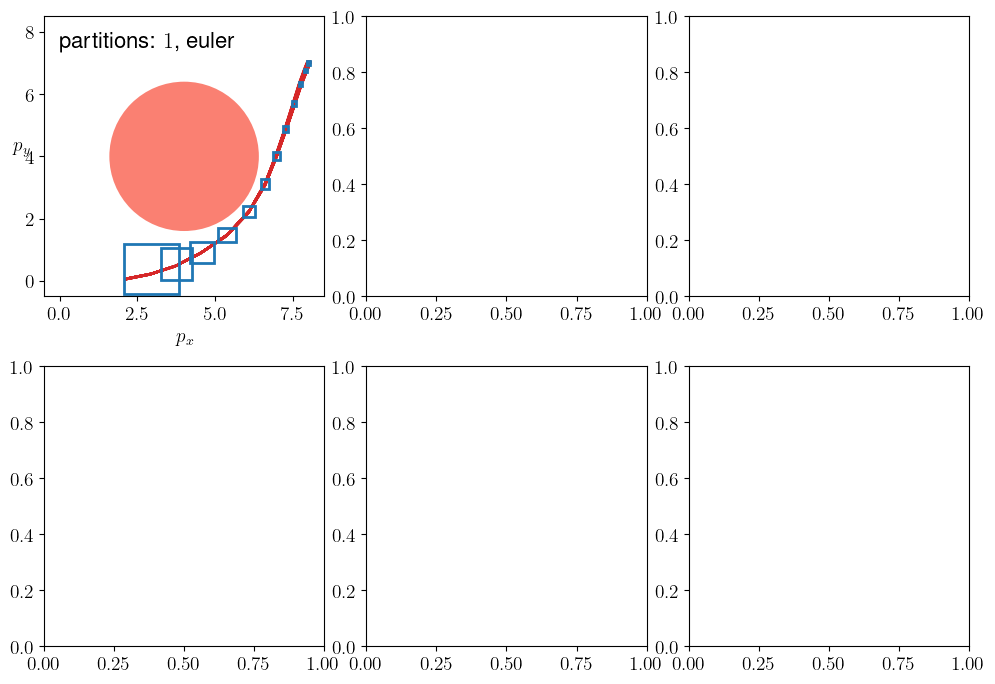

In [21]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 14
})
fig, axs = plt.subplots(2,3,dpi=100,figsize=[10,7])
fig.subplots_adjust(left=0.05, right=0.975, bottom=0.075, top=0.975, wspace=0.15, hspace=0.25)
axs = axs.reshape(-1)

for i, N in enumerate([
    (1, method, device), (2**4, method, device), (3**4, method, device),
    (4**4, method, device), (5**4, method, device), (6**4, method, device)]):
    compute_and_plot(axs[i], *N)

fig.savefig('vehicle.pdf')
plt.show()